In [5]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import category_encoders as ce
import xgboost as xgb
from sklearn.model_selection import train_test_split
from typing import Tuple

import seaborn as sns

In [14]:
filepath = "C:\\Users\\rcaldwell\\Documents\\modelling-club-team-1\\data\\Accidents\\"

In [15]:
files = os.listdir("C:\\Users\\rcaldwell\\Documents\\modelling-club-team-1\\data\\Accidents")

In [16]:
# Function to read in dates correctly
date_parser = lambda x : datetime.strptime(x, "%Y-%m-%d")
data = pd.concat([pd.read_csv(filepath+x
                   ,index_col=0
                   ,parse_dates=["date_new"]) for x in files]
                ,ignore_index=True)

data.head(10)

,Unnamed: 0.1,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,date_new
0,0,200501BS00001,525680.0,178240.0,-0.191170,51.489096,Metropolitan Police,Serious,1,1,...,None within 50 metres,Control by school crossing patrol,Daylight,Raining no high winds,Wet or damp,None,None,Urban,Yes,2005-04-01
1,1,200501BS00002,524170.0,181650.0,-0.211708,51.520075,Metropolitan Police,Slight,1,1,...,None within 50 metres,5,Darkness - lights lit,Fine no high winds,Dry,None,None,Urban,Yes,2005-05-01
2,2,200501BS00003,524520.0,182240.0,-0.206458,51.525301,Metropolitan Police,Slight,2,1,...,None within 50 metres,None within 50 metres,Darkness - lights lit,Fine no high winds,Dry,None,None,Urban,Yes,2005-06-01
3,3,200501BS00004,526900.0,177530.0,-0.173862,51.482442,Metropolitan Police,Slight,1,1,...,None within 50 metres,None within 50 metres,Daylight,Fine no high winds,Dry,None,None,Urban,Yes,2005-07-01
4,4,200501BS00005,528060.0,179040.0,-0.156618,51.495752,Metropolitan Police,Slight,1,1,...,None within 50 metres,None within 50 metres,Darkness - lighting unknown,Fine no high winds,Wet or damp,None,None,Urban,Yes,2005-10-01
5,5,200501BS00006,524770.0,181160.0,-0.203238,51.515540,Metropolitan Police,Slight,2,1,...,None within 50 metres,None within 50 metres,Daylight,Raining no high winds,Wet or damp,Oil or diesel,None,Urban,Yes,2005-11-01
6,6,200501BS00007,524220.0,180830.0,-0.211277,51.512695,Metropolitan Police,Slight,2,1,...,None within 50 metres,None within 50 metres,Darkness - lights lit,Fine no high winds,Dry,None,None,Urban,Yes,2005-01-13
7,7,200501BS00009,525890.0,179710.0,-0.187623,51.502260,Metropolitan Police,Slight,1,2,...,None within 50 metres,None within 50 metres,Daylight,Fine no high winds,Dry,None,None,Urban,Yes,2005-01-14
8,8,200501BS00010,527350.0,177650.0,-0.167342,51.483420,Metropolitan Police,Slight,2,2,...,None within 50 metres,5,Darkness - lights lit,Fine no high winds,Dry,None,None,Urban,Yes,2005-01-15
9,9,200501BS00011,524550.0,180810.0,-0.206531,51.512443,Metropolitan Police,Slight,2,5,...,None within 50 metres,8,Daylight,Fine no high winds,Dry,None,None,Urban,Yes,2005-01-15


### Vehicles

In [50]:
vehicle_filepath = "C:\\Users\\rcaldwell\\Documents\\modelling-club-team-1\\data\\Vehicles\\"
vehicle_files = os.listdir("C:\\Users\\rcaldwell\\Documents\\modelling-club-team-1\\data\\Vehicles")

In [56]:
vehicle_files

['vehicles_model_2005.csv',
 'vehicles_model_2006.csv',
 'vehicles_model_2007.csv',
 'vehicles_model_2008.csv',
 'vehicles_model_2009.csv',
 'vehicles_model_2010.csv',
 'vehicles_model_2011.csv',
 'vehicles_model_2012.csv']

In [59]:
# Function to read in dates correctly
vehicle_date_parser = lambda x : datetime.strptime(x, "%Y-%m-%d")
vehicle_data = pd.concat(pd.read_csv(vehicle_filepath + vehicle_files))

vehicle_data.head(10)

TypeError: can only concatenate str (not "list") to str

In [ ]:
# Explore variables

In [ ]:
# Aggregate correctly

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1355615 entries, 0 to 1355614
Data columns (total 33 columns):
 #   Column                                       Non-Null Count    Dtype         
---  ------                                       --------------    -----         
 0   Unnamed: 0.1                                 1355615 non-null  int64         
 1   Accident_Index                               1355615 non-null  object        
 2   Location_Easting_OSGR                        1355504 non-null  float64       
 3   Location_Northing_OSGR                       1355504 non-null  float64       
 4   Longitude                                    1355504 non-null  float64       
 5   Latitude                                     1355504 non-null  float64       
 6   Police_Force                                 1355615 non-null  object        
 7   Accident_Severity                            1355615 non-null  object        
 8   Number_of_Vehicles                           1355615

Add total darkness flag

In [48]:
data['Light_Conditions'].unique()

array(['Daylight', 'Darkness - lights lit', 'Darkness - lighting unknown',
       'Darkness - lights unlit', 'Darkness - no lighting'], dtype=object)

In [49]:
data['dark_flag'] = pd.when(data['Light_Conditions'].isin('Darkness - lights unlit', 'Darkness - no lighting'),1)

AttributeError: module 'pandas' has no attribute 'when'

In [18]:
data['Road_Surface_Conditions'].unique()

array(['Wet or damp', 'Dry', 'Frost or ice', 'Snow',
       'Flood over 3cm. deep', nan], dtype=object)

In [19]:
cat_columns = []

for i, v in enumerate(data.dtypes):
    if v == np.dtype('O'):
        cat_columns.append(data.dtypes.index[i])

# Encode response manually
cat_columns.remove('Accident_Severity')
cat_columns

['Accident_Index',
 'Police_Force',
 'Date',
 'Day_of_Week',
 'Time',
 'Local_Authority_(District)',
 'Local_Authority_(Highway)',
 '1st_Road_Class',
 'Road_Type',
 'Junction_Detail',
 'Junction_Control',
 '2nd_Road_Class',
 'Pedestrian_Crossing-Human_Control',
 'Pedestrian_Crossing-Physical_Facilities',
 'Light_Conditions',
 'Weather_Conditions',
 'Road_Surface_Conditions',
 'Special_Conditions_at_Site',
 'Carriageway_Hazards',
 'Urban_or_Rural_Area',
 'Did_Police_Officer_Attend_Scene_of_Accident']

### Variable Explore

In [20]:
np.sort(data['Police_Force'].unique())

array(['Avon and Somerset', 'Bedfordshire', 'Cambridgeshire', 'Central',
       'Cheshire', 'City of London', 'Cleveland', 'Cumbria', 'Derbyshire',
       'Devon and Cornwall', 'Dorset', 'Dumfries and Galloway', 'Durham',
       'Dyfed-Powys', 'Essex', 'Fife', 'Gloucestershire', 'Grampian',
       'Greater Manchester', 'Gwent', 'Hampshire', 'Hertfordshire',
       'Humberside', 'Kent', 'Lancashire', 'Leicestershire',
       'Lincolnshire', 'Lothian and Borders', 'Merseyside',
       'Metropolitan Police', 'Norfolk', 'North Wales', 'North Yorkshire',
       'Northamptonshire', 'Northern', 'Northumbria', 'Nottinghamshire',
       'South Wales', 'South Yorkshire', 'Staffordshire', 'Strathclyde',
       'Suffolk', 'Surrey', 'Sussex', 'Tayside', 'Thames Valley',
       'Warwickshire', 'West Mercia', 'West Midlands', 'West Yorkshire',
       'Wiltshire'], dtype=object)

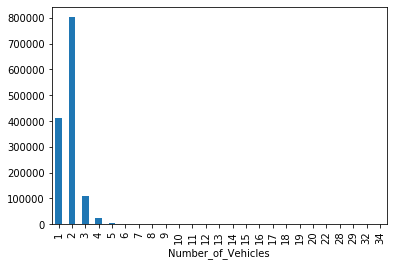

In [21]:
data.groupby(['Number_of_Vehicles']).count()["Accident_Index"].plot.bar()

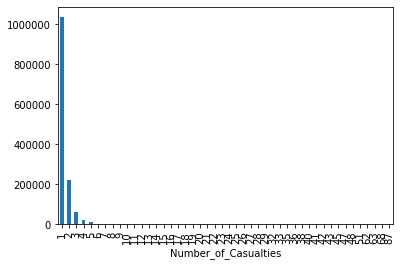

In [22]:
data.groupby(['Number_of_Casualties']).count()["Accident_Index"].plot.bar()

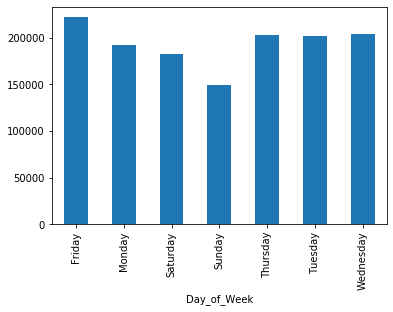

In [23]:
dowData = data.groupby(by=["Day_of_Week"]).count()["Accident_Index"]

dowData.plot.bar()

In [24]:
strToTime = lambda x: datetime.strptime(x, "%H:%M")

data['Time'] = [strToTime(str(x)) if type(x) != float else strToTime('00:00') for x in data["Time"]]

In [25]:
data['Time'].describe()

count                 1355615
unique                   1440
top       1900-01-01 17:00:00
freq                    13227
first     1900-01-01 00:00:00
last      1900-01-01 23:59:00
Name: Time, dtype: object

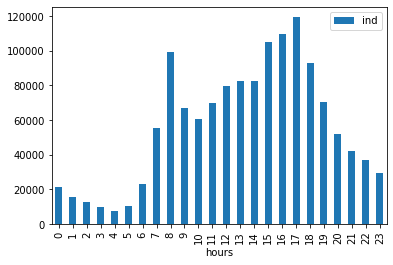

In [26]:
hours = pd.DataFrame( 
                        {"hours" : [x.hour if x!=np.nan else 0 for x in data['Time']],
                         "ind" : [1 for x in data['Time']]}
                    )\
                    .groupby('hours').count()

hours.plot.bar()

In [27]:
len(data['Local_Authority_(District)'].unique())

416

In [28]:
data\
    .groupby('Local_Authority_(District)')\
    .count()\
    .sort_values(by='Accident_Severity', ascending=False)\
    ['Accident_Severity']

Local_Authority_(District)
Birmingham                   26108
Leeds                        17994
Manchester                   13594
Glasgow City                 12687
Bradford                     12342
                             ...  
London Airport (Heathrow)      331
Western Isles                  320
Teesdale                       318
Shetland Islands               283
Orkney Islands                 226
Name: Accident_Severity, Length: 416, dtype: int64

In [29]:
len(data['Local_Authority_(Highway)'].unique())

207

In [30]:
data\
    .groupby('Local_Authority_(Highway)')\
    .count()\
    .sort_values(by='Accident_Severity', ascending=False)\
    ['Accident_Severity']

Local_Authority_(Highway)
Kent                                    36117
Surrey                                  33819
Lancashire                              30566
Essex                                   29206
Hampshire                               27182
                                        ...  
London Airport (Heathrow)                 331
Na h-Eileanan an Iar (Western Isles)      320
Shetland Islands                          283
Orkney Islands                            226
Isles of Scilly                            15
Name: Accident_Severity, Length: 207, dtype: int64

In [31]:
data['1st_Road_Class'].unique()

array(['A', 'B', 'C', 'Unclassified', 'Motorway', 'A(M)'], dtype=object)

In [32]:
data['1st_Road_Number'].head()

0    3218
1     450
2       0
3    3220
4       0
Name: 1st_Road_Number, dtype: int64

In [33]:
data['Road_Type'].unique()

array(['Single carriageway', 'Dual carriageway', 'One way street',
       'Roundabout', 'Slip road', 'Unknown'], dtype=object)

In [34]:
data['Speed_limit'].unique()

array([30, 40, 50, 20, 60, 70, 10, 15], dtype=int64)

In [35]:
data['Junction_Detail'].unique()

array(['Not at junction or within 20 metres', 'Crossroads',
       'T or staggered junction', 'Mini-roundabout', 'Other junction',
       'More than 4 arms (not roundabout)', 'Private drive or entrance',
       'Roundabout', 'Slip road', nan], dtype=object)

In [36]:
data['Junction_Control'].unique()

array([nan, 'Auto traffic signal', 'Give way or uncontrolled',
       'Stop sign', 'Authorised person',
       'Not at junction or within 20 metres'], dtype=object)

In [37]:
data['2nd_Road_Class'].unique()

array([nan, 'C', 'Unclassified', 'B', 'A', 'Motorway', 'A(M)'],
      dtype=object)

### Modelling file preparation

In [38]:
# encode variables
severity = {'Slight':0, 'Serious':1, 'Fatal':2}

data['response'] = [severity[x] for x in data['Accident_Severity']]
data['hour'] = [x.hour for x in data['Time']]

dowEncodings = pd.get_dummies(data, columns=['Day_of_Week'])
policeEncoding = pd.get_dummies(data, columns=['Police_Force'])

# Use binary encoding for Local_Authority_(District)

localAuthorityDistrictEncoder = ce.BinaryEncoder(cols=['Local_Authority_(District)'])
dfLocalAuthorityDistrict = localAuthorityDistrictEncoder.fit_transform(data['Local_Authority_(District)'])



In [39]:
encoder = ce.OrdinalEncoder(cols=cat_columns
                            ,handle_missing='na'
                            ,return_df=True
                            ,verbose=1)

encoder.fit(data)

OrdinalEncoder(cols=['Accident_Index', 'Police_Force', 'Date', 'Day_of_Week',
                     'Time', 'Local_Authority_(District)',
                     'Local_Authority_(Highway)', '1st_Road_Class', 'Road_Type',
                     'Junction_Detail', 'Junction_Control', '2nd_Road_Class',
                     'Pedestrian_Crossing-Human_Control',
                     'Pedestrian_Crossing-Physical_Facilities',
                     'Light_Conditions', 'Weather_Conditions',
                     'Road_Surfa...
Any animal in carriageway (except ridden horse)    6
NaN                                                7
dtype: int64},
                        {'col': 'Urban_or_Rural_Area', 'data_type': dtype('O'),
                         'mapping': Urban          1
Rural          2
Unallocated    3
dtype: int64},
                        {'col': 'Did_Police_Officer_Attend_Scene_of_Accident',
                         'data_type': dtype('O'),
                         'mapping': Yes            

In [40]:
# Transform variables
df = encoder.transform(data)

df.head()

,Unnamed: 0.1,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,...,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,date_new,response,hour
0,0,1,525680.0,178240.0,-0.191170,51.489096,1,Serious,1,1,...,1,1,1,1,1,1,1,2005-04-01,1,17
1,1,2,524170.0,181650.0,-0.211708,51.520075,1,Slight,1,1,...,2,2,2,1,1,1,1,2005-05-01,0,17
2,2,3,524520.0,182240.0,-0.206458,51.525301,1,Slight,2,1,...,2,2,2,1,1,1,1,2005-06-01,0,0
3,3,4,526900.0,177530.0,-0.173862,51.482442,1,Slight,1,1,...,1,2,2,1,1,1,1,2005-07-01,0,10
4,4,5,528060.0,179040.0,-0.156618,51.495752,1,Slight,1,1,...,3,2,1,1,1,1,1,2005-10-01,0,21


In [41]:
# Split data
train = df[df["date_new"] <= pd.Timestamp("2010-12-31")]
holdout = df[~df.isin(train)]

_ignore_columns = ['Unnamed: 0.1',
                   'Accident_Index',
                   'Accident_Severity',
                   'date_new'
                  ]

train = train.drop(_ignore_columns, axis=1)
holdout = holdout.drop(_ignore_columns, axis=1)

## Build Model

In [42]:
# Get list of features
model_features = train.columns.tolist()
model_features.remove('response')

response = 'response'

# Split datasets
trainSet = df.sample(frac=0.8)
testSet = df[~df.isin(trainSet)].dropna()

X_train = trainSet[model_features].values
y_train = trainSet[response].values

X_test = testSet[model_features].values
y_test = testSet[response].values

In [43]:
# Define Custom loss function for this project
def Qloss(predt : np.ndarray, dtrain : xgb.DMatrix) -> Tuple[str, float]:
    n = dtrain.num_row()
    
    response_matrix = np.ndarray(shape=(n,3), dtype=float)
    
    for i,v in enumerate(dtrain.get_label()):
        if v == 1:
            response_matrix[i,0] = v
        if v == 2:
            response_matrix[i,1] = v
        if v == 3:
            response_matrix[i,2] = v
    
    #print(predt.shape)
    one = 1 - response_matrix[predt == 0]
    two = 1 - response_matrix[predt == 1]
    three = 1 - response_matrix[predt == 2]
    
    alls = np.concatenate((one,two,three))
    
    return "QLossFunction",np.sqrt(np.sum(alls ** 2)/n)

In [44]:
# Prepare data for XGBoost Model
dtrain = xgb.DMatrix(data     =  X_train  
                     ,label   =  y_train)

dtest = xgb.DMatrix (data = X_test
                     ,label = y_test)

# XGBoost parameters
xgbparams = {
    "booster": "gbtree",
    "tree_method": "hist",
    "grow_policy": "lossguide",
    "eta": 0.1,
    "seed": 2019,
    "subsample": 0.5,
    "colsample_by_tree": 0.5,
    "max_depth": 10,
    "min_child_weight": 10,
    "objective": "multi:softmax",
    "evals": "logloss",
    "evals_metric": "logloss",
    "gamma": 0,
    "num_class": 3
}

In [45]:
# Train model
model1 = xgb.train(
         dtrain = dtrain
        ,params = xgbparams
        ,evals = [(dtrain,'train'),(dtest,'test')]
        ,num_boost_round = 20
        ,early_stopping_rounds = 50
        ,verbose_eval = 1
        ,feval = Qloss
)

[18:50:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { colsample_by_tree, evals, evals_metric } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.14708	test-merror:0.14791	train-QLossFunction:1.69295	test-QLossFunction:1.69275
Multiple eval metrics have been passed: 'test-QLossFunction' will be used for early stopping.

Will train until test-QLossFunction hasn't improved in 50 rounds.
[1]	train-merror:0.14702	test-merror:0.14785	train-QLossFunction:1.69295	test-QLossFunction:1.69275
[2]	train-merror:0.14697	test-merror:0.14783	train-QLossFunction:1.69295	test-QLossFunction:1.69275
[3]	train-merror:0.14699	test-merror:0.14785	train-QLossFunction:1.69295	test-QLossFunction:1.69275
[4]	train-merror:0.1469

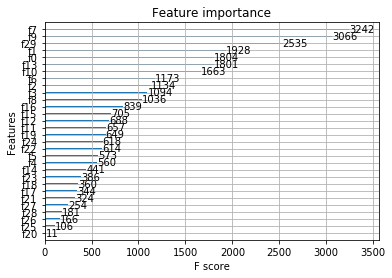

In [46]:
xgb.plot_importance(model1)